In [1]:
import numpy as np
import pandas as pd
import plotnine as pn

import matplotlib.pyplot as plt

from sciterra import Atlas, Cartographer
from sciterra.vectorization import SciBERTVectorizer,GPT2Vectorizer

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# atlas_dir = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=Word2Vec/center=hafenLowredshiftLymanLimit2017"
atlas_dir = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=Imeletal2022"
# atlas_dir = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=GPT2/center=hafenLowredshiftLymanLimit2017"

In [3]:
atl = Atlas.load(atlas_dir)
len(atl)

30212

In [4]:
print(atl.history.keys())
kernels = atl.history['kernel_size']
print(kernels.shape)
len(atl.history['pubs_per_update'])

dict_keys(['pubs_per_update', 'kernel_size'])
(30212, 118)


119

In [5]:
convergence_degrees = list(range(kernels.shape[1])) # the max convergence iteration

In [6]:
np.set_printoptions(suppress=True)
np.array([np.mean(kernels[:, i]) for i in range(kernels.shape[1])])

array([ -0.99913941,  -0.98963988,  -0.98063683,  -0.97150139,
        -0.96153846,  -0.95104594,  -0.93972594,  -0.92675096,
        -0.91675493,  -0.90235668,  -0.89358533,  -0.88286111,
        -0.87101152,  -0.8605852 ,  -0.84919899,  -0.83605852,
        -0.82073348,  -0.80716272,  -0.79216867,  -0.77604925,
        -0.76271018,  -0.7501655 ,  -0.73222561,  -0.71587449,
        -0.69823249,  -0.68131868,  -0.66516616,  -0.64735867,
        -0.62968357,  -0.61134648,  -0.5932411 ,  -0.57305044,
        -0.55342248,  -0.53260294,  -0.51267708,  -0.48950748,
        -0.47037601,  -0.44707401,  -0.42397061,  -0.40212498,
        -0.37941877,  -0.35548789,  -0.32814776,  -0.29604131,
        -0.26287568,  -0.23169601,  -0.20131074,  -0.16500066,
        -0.12756521,  -0.09377069,  -0.06037336,  -0.02446048,
         0.00847345,   0.04276446,   0.07828015,   0.12657222,
         0.18386734,   0.23599894,   0.28184165,   0.32497021,
         0.35747385,   0.42132265,   0.46392162,   0.50

In [7]:
df_kernel_evolution = pd.DataFrame(
    [
        (
            i+1, 
            np.mean(kernels[:, i]), 
            np.sum(kernels[:, i] >= 1),
            np.sum(kernels[:, i] >= 10),
            np.sum(kernels[:, i] >= 100),
            np.sum(kernels[:, i] >= 1000),
        ) 
        for i in range(kernels.shape[1])],
    columns=[
        "expansion", 
        "avg_converged_kernel_size", 
        "num_converged_for_1",
        "num_converged_for_10",
        "num_converged_for_100",
        "num_converged_for_1000",
    ],
)
# df_kernel_evolution

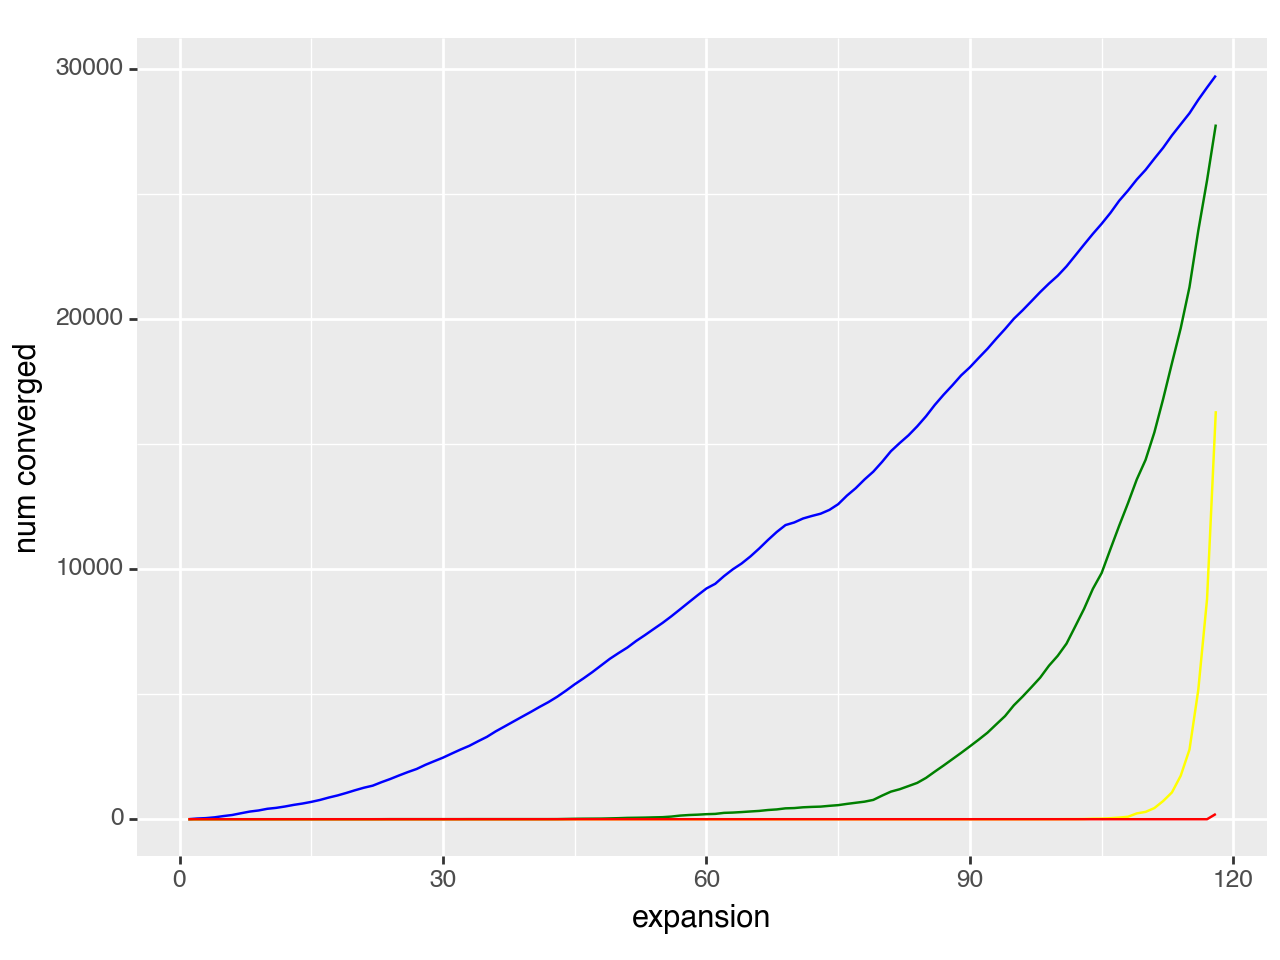

<Figure Size: (640 x 480)>

In [8]:
(
    pn.ggplot(
        df_kernel_evolution, 
        pn.aes(
            x="expansion", 
            # y="avg_converged_kernel_size",
            # y="num_converged_for_16",
        ),
    )
    # + pn.geom_point()
    + pn.geom_line(pn.aes(y="num_converged_for_1"), color="blue")
    + pn.geom_line(pn.aes(y="num_converged_for_10"), color="green")
    + pn.geom_line(pn.aes(y="num_converged_for_100"), color="yellow")
    + pn.geom_line(pn.aes(y="num_converged_for_1000"), color="red")
    + pn.ylab("num converged")
)

In [10]:
# Why not just choose the very last index always?

In [11]:
from collections import Counter
fields = Counter([field for pub in atl.publications.values() for field in pub.fields_of_study])
fields

Counter({'Linguistics': 10251,
         'Psychology': 2897,
         'Computer Science': 2668,
         'Sociology': 1536,
         'Education': 1190,
         'Mathematics': 887,
         'History': 754,
         'Medicine': 628,
         'Philosophy': 556,
         'Political Science': 330,
         'Geography': 141,
         'Art': 121,
         'Engineering': 91,
         'Business': 57,
         'Physics': 36,
         'Economics': 25,
         'Law': 24,
         'Biology': 18,
         'Geology': 8,
         'Chemistry': 6,
         'Environmental Science': 6,
         'Materials Science': 6})

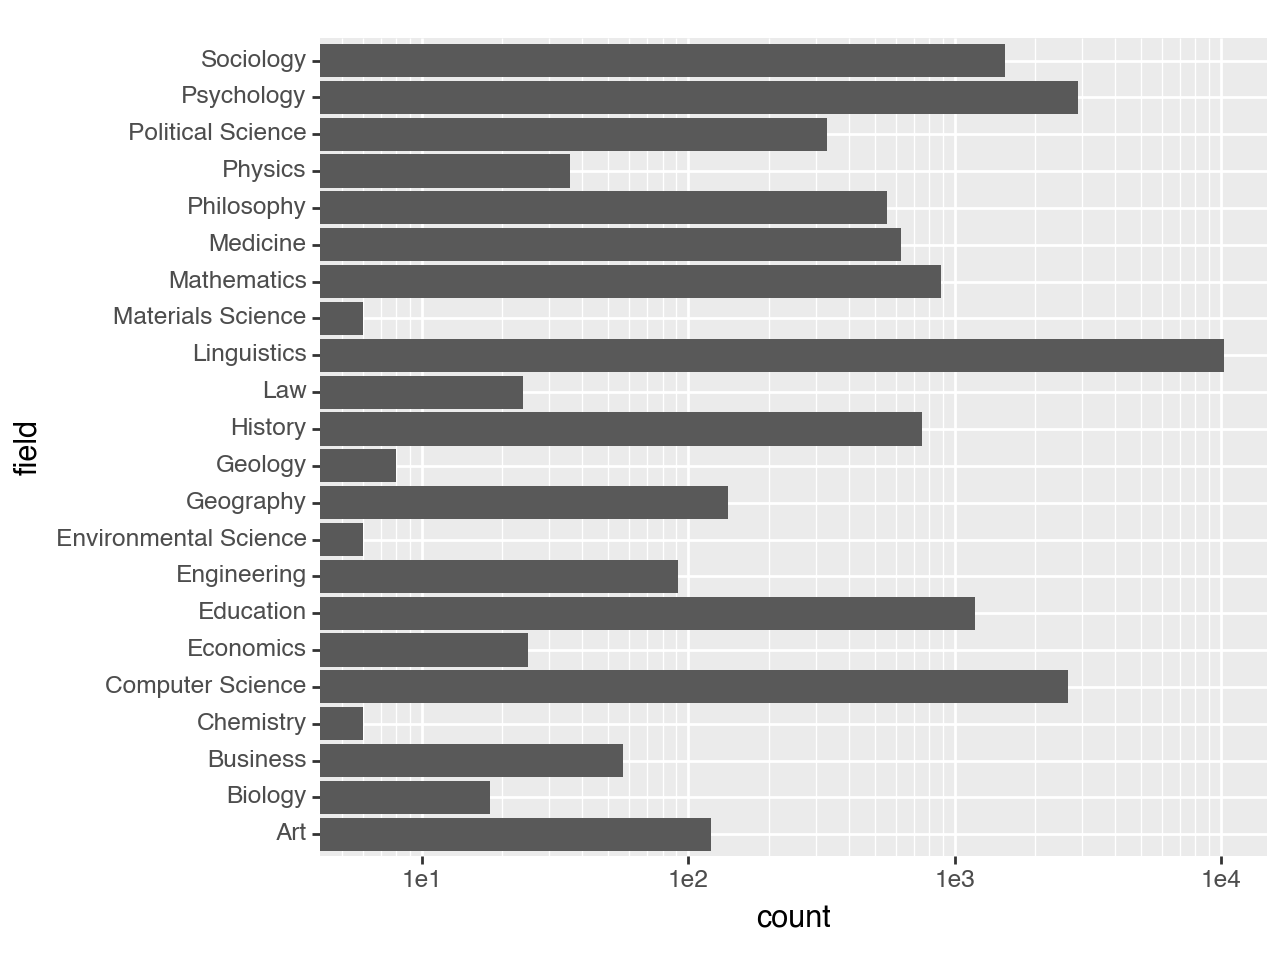

<Figure Size: (640 x 480)>

In [12]:
(
    pn.ggplot(
        data = pd.DataFrame(
            data=[(field, count) for field,count in fields.items()],
            columns=["field", "count"],
        ),
        mapping=pn.aes(x="field", y="count"),
    )
    + pn.scale_y_log10()
    + pn.geom_col()
    + pn.coord_flip()
)

In [13]:
# con_d = int(kernels.shape[1]/2)
# print(f"Setting convergence degree to len(history)/2 = {con_d}.\n")

# NOTE: idea: what if we choose the con_d s.t. it's the first update where the _avg_ kernel size is >= kernel_size?

con_d = 1 # 1 = very last
kernel_size =  16 # TODO: find a principled way of selecting this value.

# Get all publications that have not changed neighborhoods up to kernel_size for the last con_d updates
converged_filter = kernels[:, -con_d] >= kernel_size
ids = np.array(atl.projection.index_to_identifier)
converged_pub_ids = ids[converged_filter]

[atl[id].title for id in converged_pub_ids][:10]

['Modal semantic universals optimize the simplicity/informativeness trade-off',
 'Predicting Pragmatic Reasoning in Language Games',
 'The Expression of Modality in Tlingit: A Paucity of Grammatical Devices1',
 'A Variable-Force Variable-Flavor Attitude Verb in Koryak∗',
 'Indefinite Pronouns Optimize the Simplicity/Informativeness Trade‐Off',
 'Reverse-engineering the language of thought: A new approach',
 'Efficient compression in color naming and its evolution',
 'Variable Modality in Pintupi-Luritja Purposive Clauses',
 'The forms and meanings of grammatical markers support efficient communication',
 'A Database for Modal Semantic Typology']

In [14]:
# Filter to physics!
# Filter to linguistics!
converged_pub_ids = [id for id in converged_pub_ids if "Linguistics" in atl[id].fields_of_study]
len(converged_pub_ids)

6962

In [15]:
crt = Cartographer(
    vectorizer=SciBERTVectorizer()
    # vectorizer=GPT2Vectorizer(),
)

Using device: cpu.


In [16]:
measurements = crt.measure_topography(
    atl, 
    ids=converged_pub_ids,
    metrics=["density", "edginess"], 
    kernel_size=kernel_size,
)

computing cosine similarity for 6962 embeddings with batch size 1000.


100%|██████████| 7/7 [00:00<00:00,  9.32it/s]


Computing ['density', 'edginess'] for 6962 publications.


100%|██████████| 6962/6962 [00:03<00:00, 1998.26it/s]


In [17]:
# get citations
citations_per_year = [ 
    atl[id].citation_count / (2023 - atl[id].publication_date.year) if (atl[id].publication_date.year < 2023 and atl[id].citation_count is not None) else 0.
    for id in converged_pub_ids
]

In [18]:
df = pd.DataFrame(
    measurements,
    columns=["density", "edginess"],
)
df["citations_per_year"] = citations_per_year

df = df[~np.isinf(df["density"])] # drop infs which occur for BOW vectorizer

df.dropna(inplace=True, ) 

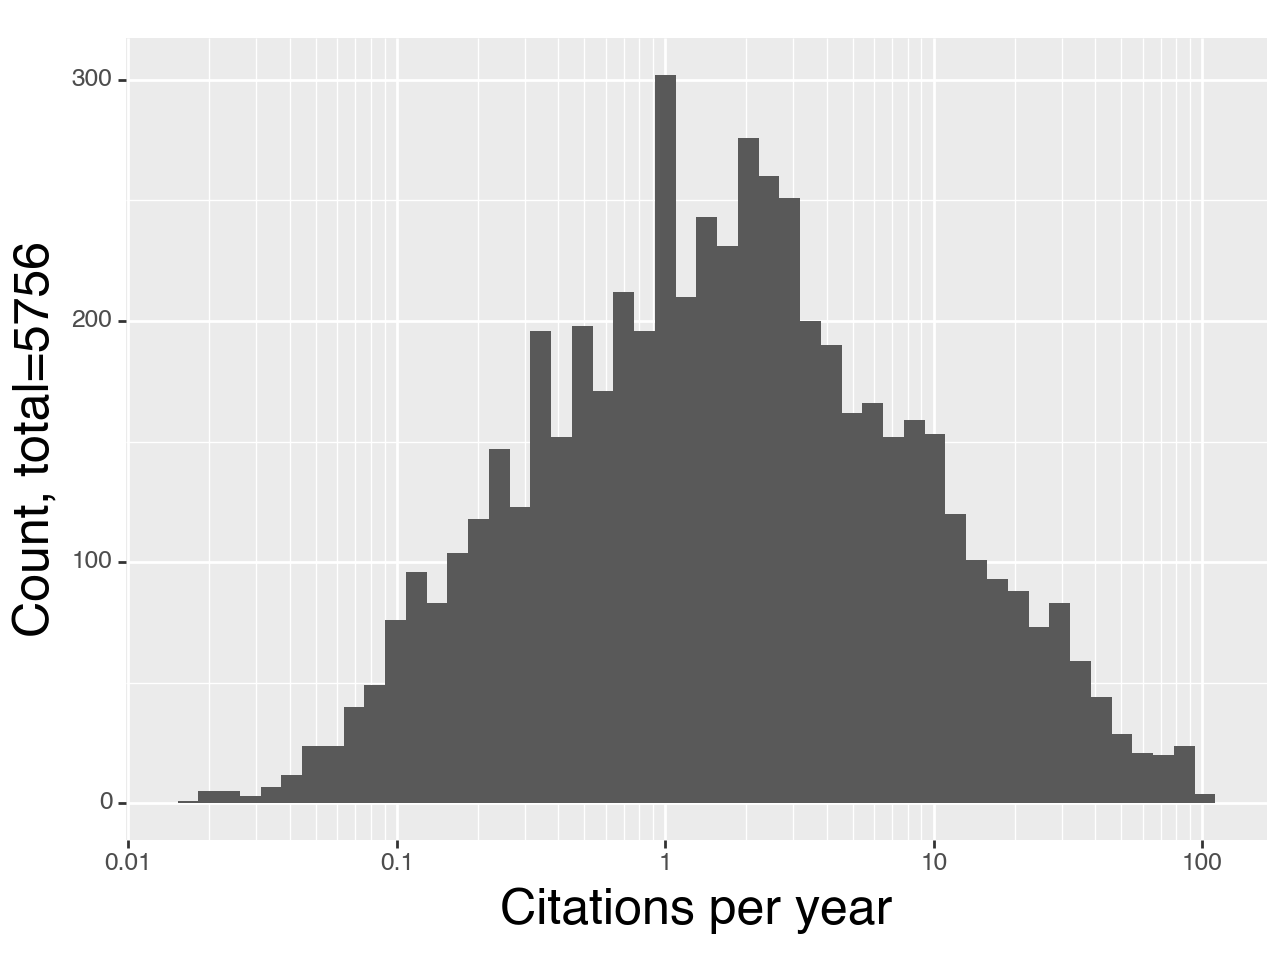

<Figure Size: (640 x 480)>

In [19]:
df_f = df[(df["citations_per_year"] > 0) & (df["citations_per_year"] <= 100.)]

(
    pn.ggplot(
        # df,
        df_f,
        mapping=pn.aes(x="citations_per_year")
    )
    + pn.geom_histogram(bins=50)
    + pn.scale_x_log10()
    + pn.xlab("Citations per year")
    + pn.ylab(f"Count, total={len(df_f)}")
    + pn.theme(
        axis_title=pn.element_text(size=18)
    )
)

In [20]:
# How many points are N cpy and below?
N = df["citations_per_year"].mean() + 1*df["citations_per_year"].std()
cpy = df["citations_per_year"]
print(f"{len(cpy[cpy <= N])}/{len(cpy)} = ({len(cpy[cpy <= N]) / len(cpy) * 100} %) of publications received <= {N} cpy")

6581/6921 = (95.0874151134229 %) of publications received <= 26.68416222905713 cpy


In [21]:
# How many points are M density and below
M = df["density"].mean() + 1*df["density"].std()
M = 60
rho = df["density"]
print(f"{len(rho[rho <= N])}/{len(rho)} = ({len(rho[rho <= M]) / len(rho) * 100} %) of publications have <= {M} density")

1563/6921 = (99.79771709290564 %) of publications have <= 60 density


In [22]:
df_filtered = df[(df["citations_per_year"] > 0) & (df["citations_per_year"] <= N)]
df_filtered = df_filtered[df_filtered["density"] <= M]

In [24]:
(
    pn.ggplot(
        df_filtered,
        mapping=pn.aes(
            x="density", 
            # x="edginess",
            y="citations_per_year",
        )
    )
    + pn.geom_point(
        alpha=0.2,
    )
    + pn.geom_density_2d_filled()
    + pn.xlab("Density")
    # + pn.xlab("Asymmetry")
    + pn.ylab("Citations per year")
    + pn.geom_smooth(color="orange", size=2)
    + pn.theme(
        # axis_title_y=pn.element_blank(),
        axis_title=pn.element_text(size=18),
    )
)

AttributeError: module 'plotnine' has no attribute 'geom_density_2d_filled'

TODO: dump the data to a csv, and see if get different results in R

In [ ]:
df_filtered.to_csv("df_filtered.csv")

Connor feedback:

- Use a nonlinear regression, since that's obviously the relationship
- You can use likelihood ratio test, AIC and BIC, though the former is probably fine and easiest since latter requires params to be shared across models. 
- Density sweet spot is intuitive, but no relationship at all is interesting too!

Try to compute the running median

In [ ]:
# TODO: write it out by hand.